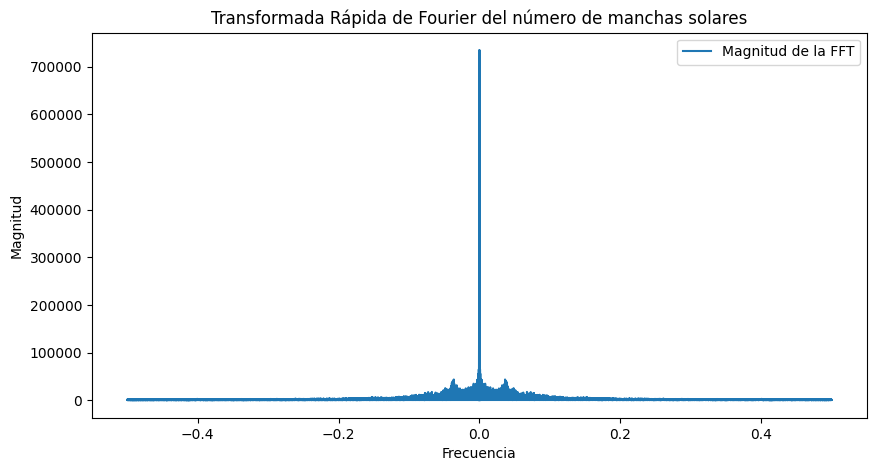

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
url = "https://www.ngdc.noaa.gov/stp/space-weather/solar-data/solar-indices/sunspot-numbers/american/lists/list_aavso-arssn_daily.txt"
data = pd.read_csv(url, delim_whitespace=True, header=None, names=["Year", "Month", "Day", "Sunspot_Number"])
data = data.dropna(subset=["Year", "Month", "Day"])
data = data[data["Year"].apply(lambda x: str(x).isdigit())]
data = data[data["Month"].apply(lambda x: str(x).isdigit())]
data = data[data["Day"].apply(lambda x: str(x).isdigit())]
data["Year"] = data["Year"].astype(int)
data["Month"] = data["Month"].astype(int)
data["Day"] = data["Day"].astype(int)
data['Date'] = pd.to_datetime(data[["Year", "Month", "Day"]])
filtered_data = data[data["Date"] <= "2012-01-01"]
filtered_data.loc[:, "Sunspot_Number"] = pd.to_numeric(filtered_data["Sunspot_Number"], errors="coerce")
filtered_data = filtered_data.dropna(subset=["Sunspot_Number"])
promedio = filtered_data["Sunspot_Number"].mean()
filtered_data.loc[:, "Sunspot_Number"] -= promedio
trasn_f_discreta = np.fft.fft(filtered_data["Sunspot_Number"])
freq = np.fft.fftfreq(len(filtered_data["Sunspot_Number"]), d=1)
plt.figure(figsize=(10, 5))
plt.plot(freq, np.abs(trasn_f_discreta), label="Magnitud de la FFT")
plt.title("Transformada Rápida de Fourier del número de manchas solares")
plt.xlabel("Frecuencia")
plt.ylabel("Magnitud")
plt.legend()





Punto 1.1

In [2]:

f_principal_idx = np.argmax(np.abs(trasn_f_discreta))

f_principal = np.abs(freq[f_principal_idx])
print(f_principal)
p_dias = 1 / f_principal
print(f"El período del ciclo solar en días es aproximadamente: {p_dias:.2f} días")

p_años = p_dias / 365.25
print(f"El período del ciclo solar en años es aproximadamente: {p_años:.2f} años")


0.0002451781627983001
El período del ciclo solar en días es aproximadamente: 4078.67 días
El período del ciclo solar en años es aproximadamente: 11.17 años


Punto 1.2

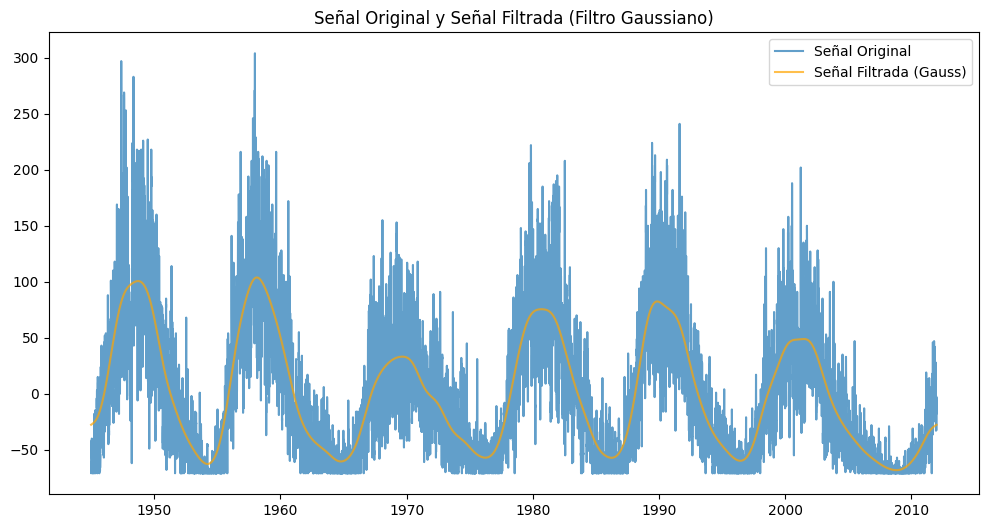

In [3]:

n = len(filtered_data["Sunspot_Number"])
freq = np.fft.fftfreq(n, d=1)

filtro_gauss = np.exp(-((freq * 1000) ** 2))

#filtro_threshold = np.where(np.abs(freq) < 0.001, 1, 0)

señal_filtrada_gauss = np.fft.ifft(trasn_f_discreta * filtro_gauss)
#señal_filtrada_threshold = np.fft.ifft(trasn_f_discreta * filtro_threshold)
plt.figure(figsize=(12, 6))
plt.plot(filtered_data["Date"], filtered_data["Sunspot_Number"], label="Señal Original", alpha=0.7)
plt.plot(filtered_data["Date"], señal_filtrada_gauss.real, label="Señal Filtrada (Gauss)", alpha=0.7, color="orange")
plt.title("Señal Original y Señal Filtrada (Filtro Gaussiano)")
plt.legend()


12.a

Text(0.5, 1.0, 'Transformada Filtrada')

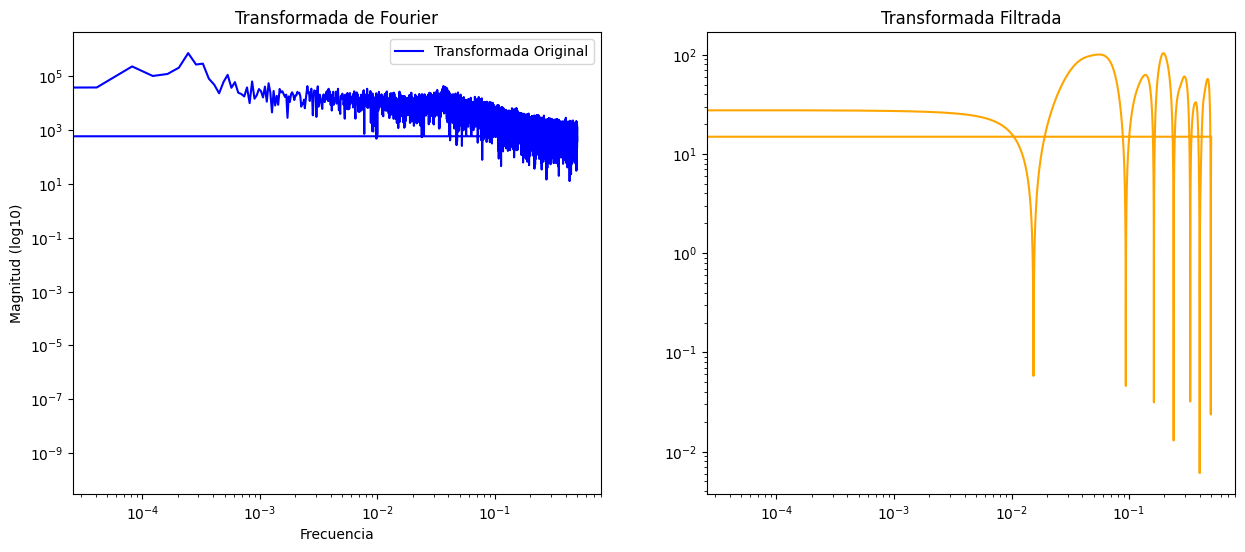

In [6]:
mag_transformada = np.abs(trasn_f_discreta)
mag_transformada_filtrada = np.abs(señal_filtrada_gauss)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.loglog(freq, mag_transformada, label='Transformada Original', color='blue')
plt.title("Transformada de Fourier")
plt.xlabel("Frecuencia")
plt.ylabel("Magnitud (log10)")
plt.legend()
plt.subplot(1, 2, 2)
plt.loglog(freq, mag_transformada_filtrada, label='Transformada Filtrada (Gauss)', color='orange')
plt.title("Transformada Filtrada")



1.2b

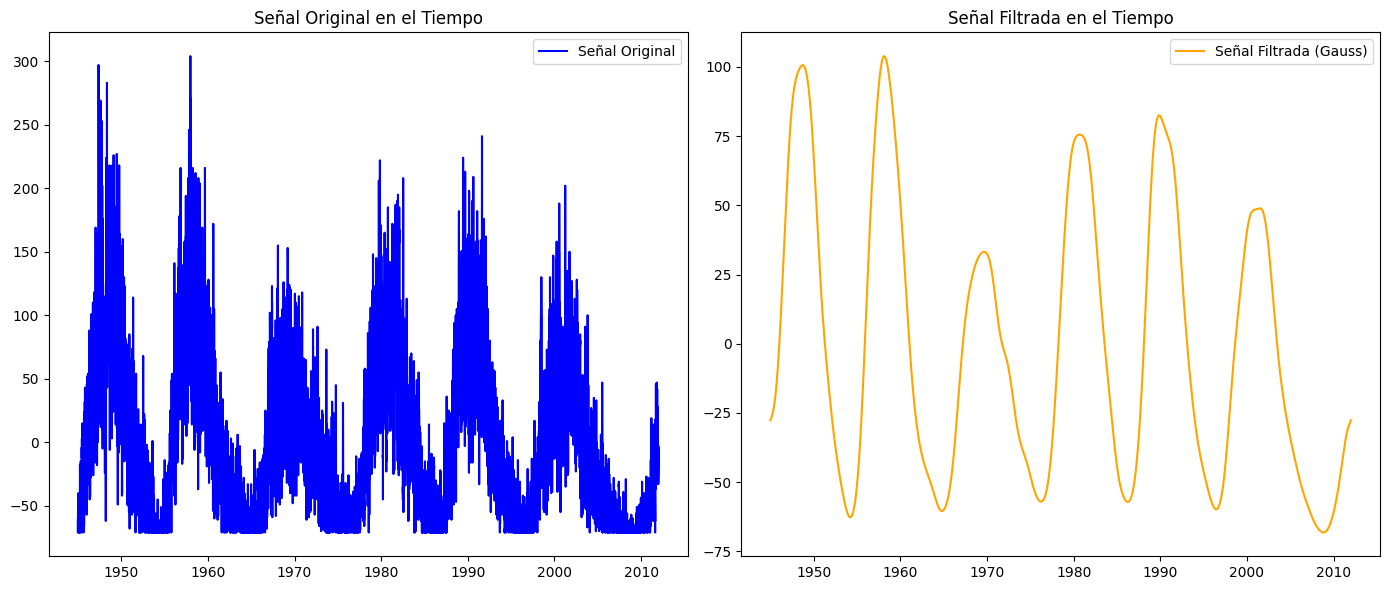

In [8]:
señal_filtrada_gauss = np.fft.ifft(trasn_f_discreta * filtro_gauss).real
plt.figure(figsize=(14, 6))


plt.subplot(1, 2, 1)
plt.plot(filtered_data["Date"], filtered_data["Sunspot_Number"], label="Señal Original", color="blue")
plt.title("Señal Original en el Tiempo")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(filtered_data["Date"], señal_filtrada_gauss, label="Señal Filtrada (Gauss)", color="orange")
plt.title("Señal Filtrada en el Tiempo")
plt.legend()

plt.tight_layout()



Text(0.5, 1.0, 'Señal Original y Extrapolada')

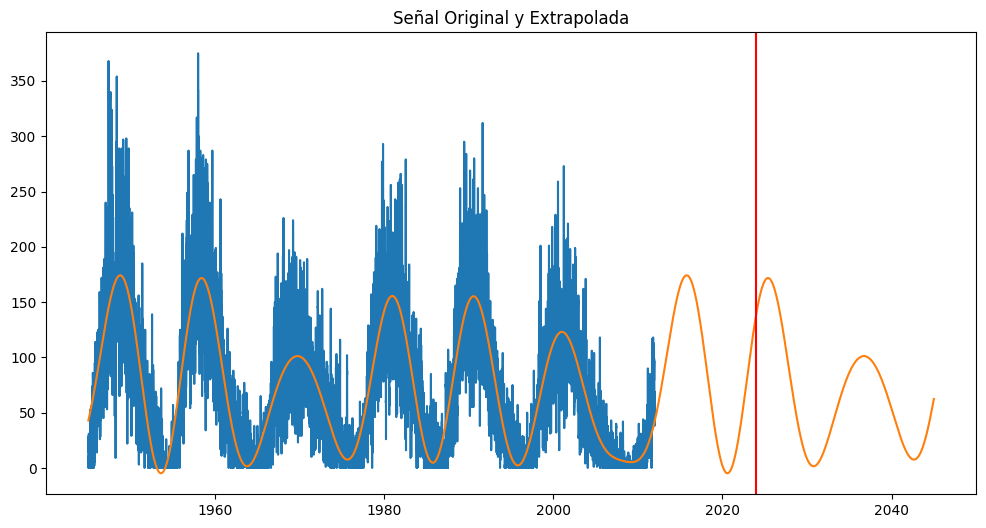

In [10]:
primeras_10f = freq[:10]
ultimas_10f = freq[-10:]
primeras_10TF = trasn_f_discreta[:10]
ultimas_10TF = trasn_f_discreta[-10:]

Fourier = np.concatenate([primeras_10TF, ultimas_10TF])
frecuencias = np.concatenate([primeras_10f, ultimas_10f])

def transformada_i_m(f, F, t):
    return (np.sum(F[:, None] * np.exp(1j * 2 * np.pi * f[:, None] * t[None, :]), axis=0)) / len(filtered_data)

o_date = pd.date_range(filtered_data['Date'].min(), pd.to_datetime('2045-01-01'), freq='D')
o = np.arange(len(o_date))

plt.figure(figsize=(12, 6))
plt.plot(filtered_data["Date"], filtered_data["Sunspot_Number"] + promedio, label="Señal Original")
plt.plot(o_date, transformada_i_m(frecuencias, Fourier, o) + promedio, label="Señal Extrapolada")
plt.axvline(x=pd.to_datetime("2024-01-01"), color="red", label="Fecha de Referencia")
plt.title("Señal Original y Extrapolada")


In [12]:

fecha_objetivo = pd.to_datetime("2024-08-15")
indice_fecha_objetivo = np.where(o_date == fecha_objetivo)[0][0]
manchas_estimadas = abs(transformada_i_m(frecuencias, Fourier, o)[indice_fecha_objetivo] + promedio)

print(f"En agosto de 2024 estamos en {'máximo' if manchas_estimadas > promedio else 'mínimo'} solar.")
print(f"Se deberían esperar aproximadamente {manchas_estimadas:.2f} manchas solares a mediados de agosto de 2024.")


En agosto de 2024 estamos en máximo solar.
Se deberían esperar aproximadamente 161.49 manchas solares a mediados de agosto de 2024.


Tranformada 2D

Punto 2


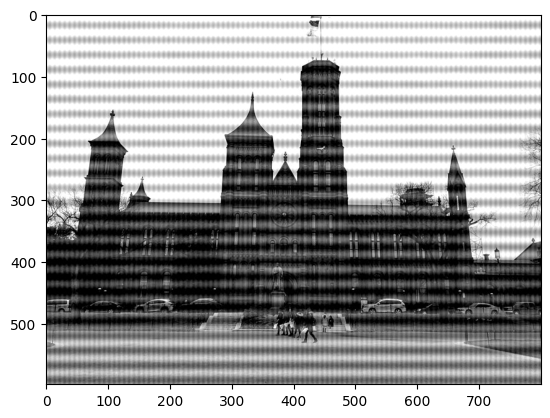

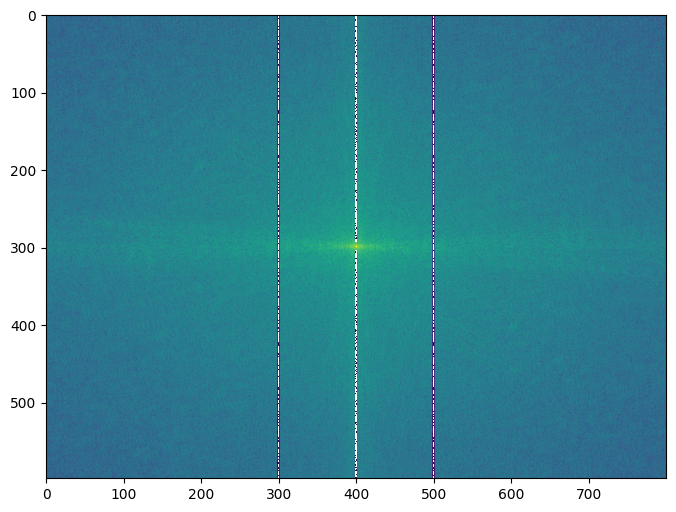

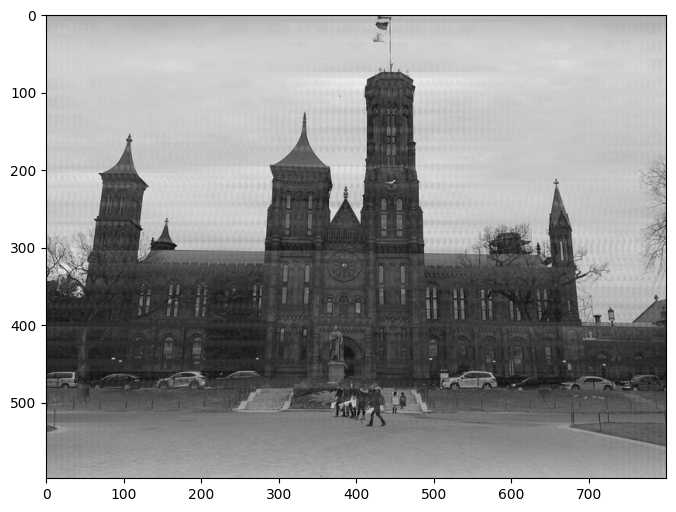

In [23]:
import requests
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO

img_array = np.array(Image.open("castle.jpg")).astype(float)



plt.imshow(img_array,cmap="gray")


transformada_fourier_b = np.fft.fft2(img_array)
centrar = np.fft.fftshift(transformada_fourier_b)

centrar[0:294,398:402]=0
centrar[304:600,398:402]=0
centrar[0:1200,498:502]=0
centrar[0:1200,298:302]=0

plt.figure(figsize=(8,8))

np.size(centrar[0])
plt.imshow(abs(centrar),norm="log")



transformada_inversa= np.fft.ifft2(np.fft.ifftshift(centrar))

plt.figure(figsize=(8,8))
plt.imshow(np.real(transformada_inversa), cmap = "gray")

